<a href="https://colab.research.google.com/github/bori00/BrainTumorClassification/blob/bori_dev/BrainTumorClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain Tumor Classification

## Introduction

Just a few things that I found and may help you:

Summary:

**Glioma tumors**

*   cause: glial cells grow out of control due to DNA changes
*   type: **malignant** (cancerous)
*   location: depends on the subtype.
*   treatment: possible, but difficult (hard to reach with surgery, may grow into other areas of the brain). Requires a combination of surgery, radiation therapy and chemotherapy
*   frequency: ~25% of all detected brain tumors are gliomas
*   diagnosis: first, an MRI or CT scan is made. If an abnormal mass is found, a biopsy is made. 
*   treatment: the primary treatment is surgery, which is usually followed by chemotherapy and radiation therapy.
*  [source](https://my.clevelandclinic.org/health/diseases/21969-glioma#:~:text=A%20glioma%20is%20a%20tumor%20that%20forms%20when%20glial%20cells,can%20be%20very%20slow%20growing.)

**Meningioma tumors**

*  cause: 40-80% of all meningiomas have an abnormality in chromosome 22, which is partially responsible for surpressing the growth of tumors. Also, a correlation between hormones and meningiomas were found.
*   type: 
  *   grade I: **bening**, and grows slowly
  *   grade II: atypical, grows more quickly
  *   grade III: **malignant**, grows and spreads quickly
*  location: generally found on the outer surface the brain. The source is the menigers, the layers of tissue that cover the brain and spinal cord
*  frequency: represent ~33% of all brain tumors
*  diagnosis: the first step involves an MRI or a CT scan, and it is sometimes enough for a full diagnosis. Otherwise, a biopsy may be needed.
*  treatment: usually by radiosurgery and surgery. Chemotherapy is only applied for malignant tumors.
*  [source](https://my.clevelandclinic.org/health/diseases/17858-meningioma)


**Pituitary tumors**


*   cause: accidental changes in the DNA
*   type: mostly **bening**, and they do not spread in other parts of the body. 
*   location: in the pituitary gland (found behind the nose and the sphenoid sinus). May cause a hormone deficiency.
*   diagnosis: an MRI or CT scan is usually enough, together with a medical background check
*   frequency: doctors found that almost 25% of the populations had a pituitary adenoma, but most of them are never detected. Approximately 12.5% of all brain tumors are pituitary tumors.
*   treatment: usually, immediate treatment is not required. The tumor may be removed, the growth may be controlled or the hormone levels may be managed with medications. 
*   [source1](https://my.clevelandclinic.org/health/diseases/15328-pituitary-adenomas-), [source2](https://www.mayoclinic.org/diseases-conditions/pituitary-tumors/symptoms-causes/syc-20350548#:~:text=A%20pituitary%20tumor%20is%20a,develop%20in%20your%20pituitary%20gland) 

## Setup

In [ ]:
# Imports
import os, warnings
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import gridspec
import seaborn as sns

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import urllib
from urllib import request

import time

from numpy.random import seed

from yellowbrick.classifier import ClassPredictionError

In [ ]:
pip install -U matplotlib

In [ ]:
# Reproducability
SEED = 31415
def set_seed(seed_value=SEED):
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    seed(seed_value)
set_seed()

## Import Dataset

In [ ]:
# mount google drive on the virtual machine created by colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# unzip the files containing the training and testing images
# important: this step assumes that you have the two zip files in 'BrainTumorClassification/Training.zip' and 'BrainTumorClassification/Testing.zip' in your Google Drive
!unzip gdrive/My\ Drive/BrainTumorClassification/Training.zip
!unzip gdrive/My\ Drive/BrainTumorClassification/Testing.zip

## Create Dataframes

Not all images ae of the same size, but 5012x512 is close to their original size.

In [ ]:
IMAGE_SIZE = (512, 512)
BATCH_SIZE = 32

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  'Training',
  shuffle=True,
  validation_split=0.2,
  subset="training",
  color_mode="grayscale",
  seed=SEED,
  image_size=IMAGE_SIZE, 
  batch_size=BATCH_SIZE)

valid_ds = tf.keras.utils.image_dataset_from_directory(
  'Training',
  shuffle=True,
  validation_split=0.2,
  subset="validation",
  color_mode="grayscale",
  seed=SEED,
  image_size=IMAGE_SIZE, 
  batch_size=BATCH_SIZE)

test_ds = tf.keras.utils.image_dataset_from_directory(
  'Testing',
  shuffle=True,
  seed=SEED,
  color_mode="grayscale",
  image_size=IMAGE_SIZE, 
  batch_size=BATCH_SIZE)

Found 2870 files belonging to 4 classes.
Using 2296 files for training.
Found 2870 files belonging to 4 classes.
Using 574 files for validation.
Found 394 files belonging to 4 classes.


In [ ]:
for x, y in train_ds.take(1):
  print("Shape of one batch in the   training dataset: ", x.shape, " with labels:", y)

for x, y in valid_ds.take(1):
  print("Shape of one batch in the validation dataset: ", x.shape, " with labels:", y)

for x, y in test_ds.take(1):
  print("Shape of one batch in the    testing dataset: ", x.shape, " with labels:", y)

Shape of one batch in the   training dataset:  (32, 512, 512, 1)  with labels: tf.Tensor([3 1 1 2 1 0 1 1 3 0 1 2 1 3 3 3 0 2 3 3 3 1 2 2 3 1 3 0 1 3 3 0], shape=(32,), dtype=int32)
Shape of one batch in the validation dataset:  (32, 512, 512, 1)  with labels: tf.Tensor([3 1 0 1 3 3 1 0 2 1 2 0 2 1 0 1 0 3 3 0 3 2 1 0 1 1 0 2 3 3 0 3], shape=(32,), dtype=int32)
Shape of one batch in the    testing dataset:  (32, 512, 512, 1)  with labels: tf.Tensor([3 3 1 0 2 0 2 2 3 1 2 1 2 0 2 1 2 1 2 0 2 0 1 0 1 1 2 3 1 1 2 3], shape=(32,), dtype=int32)


In [ ]:
class_names = train_ds.class_names
print("Class Names: ", class_names)

Class Names:  ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


### Distributions

In [ ]:
def get_distribution(ds):
  vals = np.unique(np.fromiter(ds.unbatch().map(lambda x, y: y), float), return_counts=True)
  dist = [0, 0, 0, 0]

  for val, count in zip(*vals):
    dist[int(val)] = count
  
  return dist

In [ ]:
training_dist = get_distribution(train_ds)
valid_dist = get_distribution(valid_ds)
testing_dist = get_distribution(test_ds)

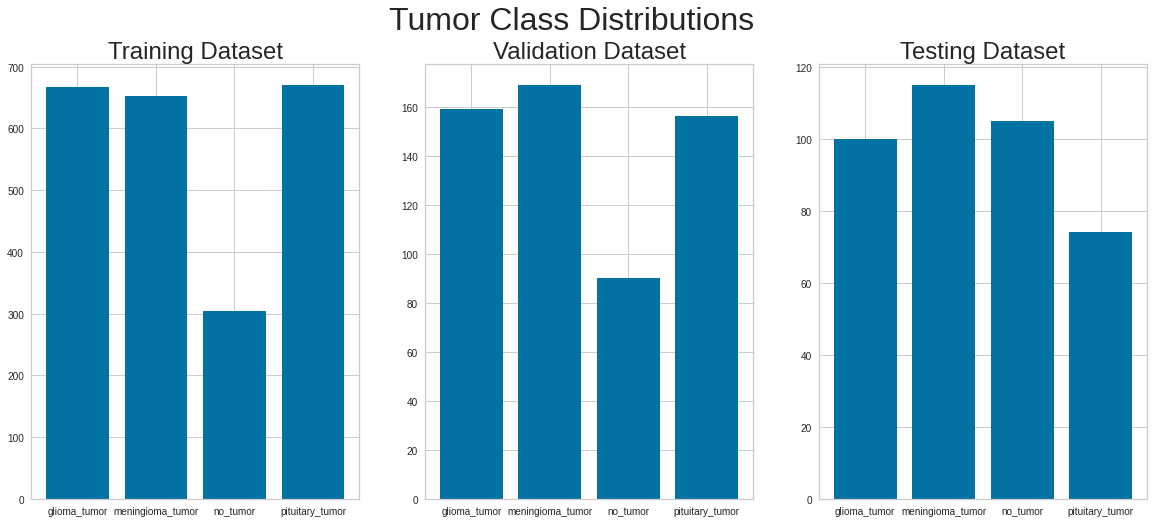

In [ ]:
plt.figure(figsize=(20, 8))
plt.suptitle("Tumor Class Distributions", fontsize = 32)

plt.subplot(1, 3, 1)
plt.title("Training Dataset", fontsize = 24)
plt.bar(range(len(training_dist)), training_dist, tick_label=class_names)

plt.subplot(1, 3, 2)
plt.title("Validation Dataset", fontsize = 24)
plt.bar(range(len(valid_dist)), valid_dist, tick_label=class_names)

plt.subplot(1, 3, 3)
plt.title("Testing Dataset", fontsize = 24)
plt.bar(range(len(testing_dist)), testing_dist, tick_label=class_names)

plt.show()

The training and validation dataset are well-balanced, as they were programatically generated, but the test dataset, downloaded from kaggle, has a significantly different class distribution from that of the other datasets: the no_tumor class is overrepresented in the test dataset compared to the other two.

## Visualize data

In [ ]:
def categorize_images(batch):
  cardinalities = [0, 0, 0, 0]
  cat_images = [[], [], [], []]

  for images, labels in batch:
    for i in range(images.shape[0]):
        category = int(labels[i])
        cardinalities[category] = cardinalities[category] + 1
        cat_images[category].append(images[i].numpy().astype("uint8"))
  
  return cat_images, cardinalities

In [ ]:
def visualize_batch_per_categories(batch):
  cat_images, cardinalities = categorize_images(batch)

  no_columns = max(cardinalities)

  # create 4x1 subplots
  fig, axs = plt.subplots(nrows=4, ncols=1, constrained_layout=True)
  fig.set_figheight(20)
  fig.set_figwidth(4 * no_columns)
  fig.suptitle('The content of one Batch', fontsize = 64)

  # clear subplots
  for ax in axs:
      ax.remove()

  # add subfigure per subplot
  gridspec = axs[0].get_subplotspec().get_gridspec()
  subfigs = [fig.add_subfigure(gs) for gs in gridspec]

  for row, subfig in enumerate(subfigs):
      subfig.suptitle(class_names[row], fontsize = 32)

      # create 1x3 subplots per subfig
      axs = subfig.subplots(nrows=1, ncols=no_columns)
      for col, ax in enumerate(axs):
          if (cardinalities[row] > col):
            ax.plot()
            ax.grid(False)
            ax.imshow(cat_images[row][col-1], cmap="gray")

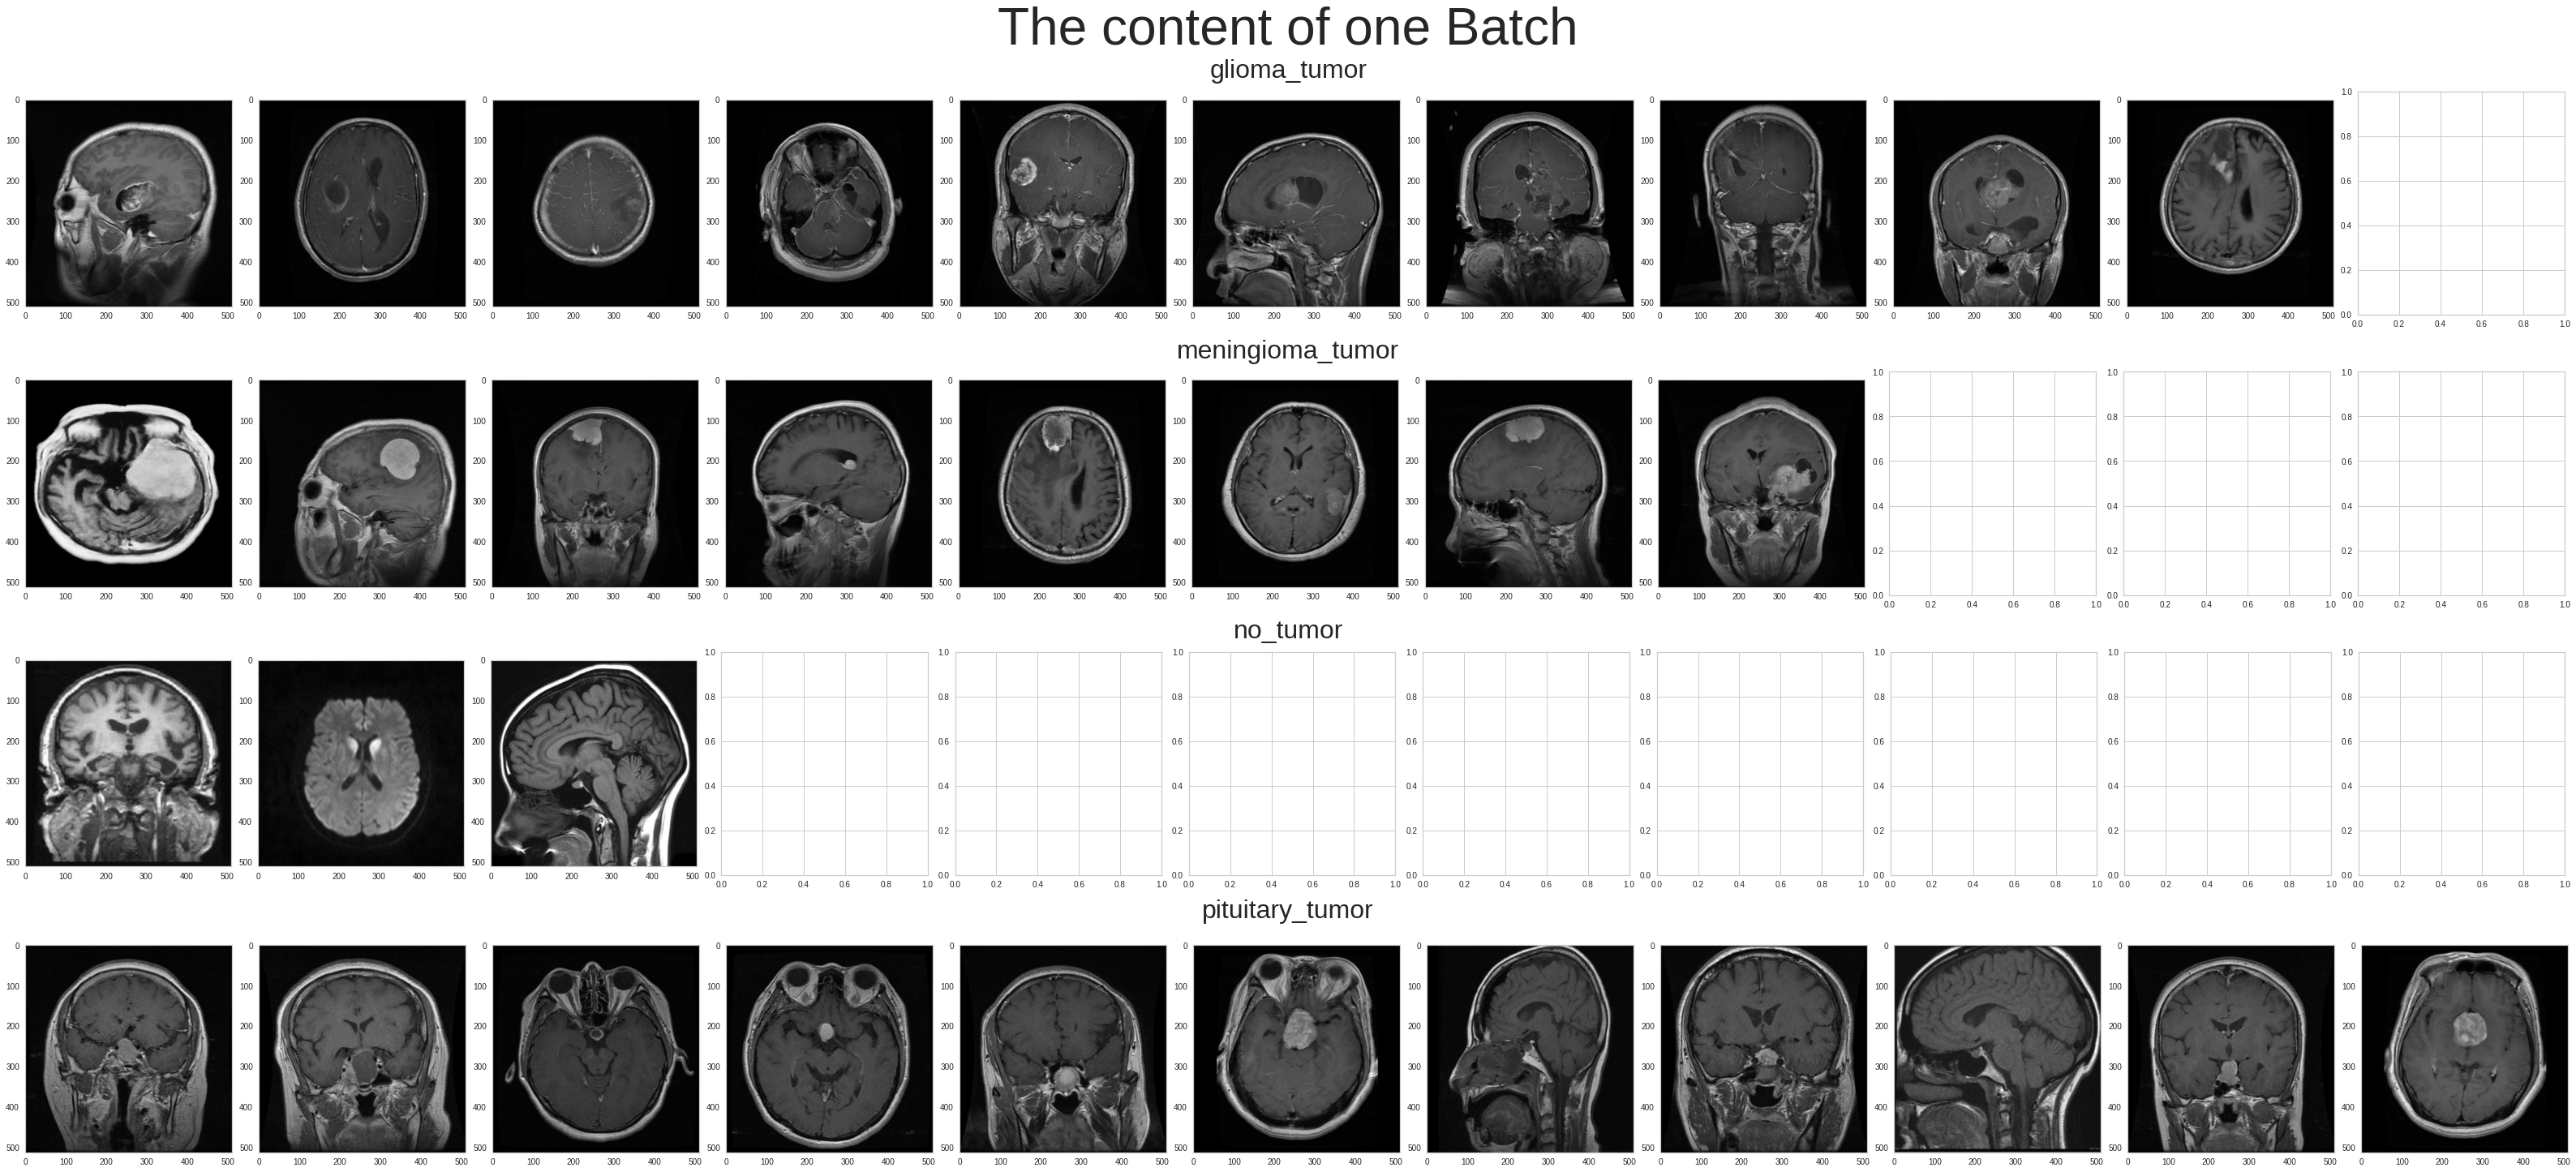

In [ ]:
visualize_batch_per_categories(train_ds.take(1))

## Performance configurations

Source: [tensorflow tutorial](https://www.tensorflow.org/tutorials/images/classification)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Preprocessing

Let's find the range of the color intensities:

In [ ]:
def get_sample_image_values_range(ds):
  image_batch, labels_batch = next(iter(ds))
  first_image = image_batch[0]
  # Notice the pixel values are now in `[0,1]`.
  return np.min(first_image), np.max(first_image)

In [ ]:
print("Sample image's values' range: ", get_sample_image_values_range(train_ds))

Sample image's values' range:  (0.0, 255.0)


Because neural networks work better with small values, we should scale the [0, 255] pixel color values to [0, 1]. 

In [ ]:
def rescale_pixels(ds):
  rescaler = tf.keras.layers.Rescaling(1./255.0)
  return ds.map(lambda x, y: (rescaler(x), y))

In [ ]:
train_ds = rescale_pixels(train_ds)
valid_ds = rescale_pixels(valid_ds)
test_ds = rescale_pixels(test_ds)

## Expectations from the model

Before starting to design and train a machine learning model for classifying MRI images, we should think about what the goal of this classifier is, what is the metric that we want to maximize.



## Creating a model

### Helper functions

In [ ]:
def plot_loss_accuracy_history(history):
  plt.figure(figsize=(16, 8))

  plt.subplot(1, 2, 1)
  plt.plot(pd.DataFrame(history.history['accuracy']))
  plt.plot(pd.DataFrame(history.history['val_accuracy']))
  plt.grid(True)
  plt.title("Accuracy")
  plt.gca().legend(('training accuracy', 'validation accuracy'))

  plt.subplot(1, 2, 2)
  plt.plot(pd.DataFrame(history.history['loss']))
  plt.plot(pd.DataFrame(history.history['val_loss']))
  plt.grid(True)
  plt.title("Loss")
  plt.gca().legend(('training loss', 'validation loss'))
  plt.show()

In [ ]:
def get_images_labels_from_ds(ds):
  images = np.concatenate([x for x, y in valid_ds], axis=0)
  labels = np.concatenate([y for x, y in valid_ds], axis=0)
  return images, labels

In [ ]:
def get_label_predictions(images, model):
  pred_raw = model.predict(images)
  pred_prob = tf.nn.softmax(pred_raw)
  pred_class = [np.int64(np.argmax(prob)) for prob in pred_prob]
  return pred_class

In [ ]:
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
  conf_mat = confusion_matrix(y_true, y_pred)
  cm_df = pd.DataFrame(conf_mat,
                     index = class_names, 
                     columns = class_names)
  plt.figure(figsize=(8,6))
  g = sns.heatmap(cm_df, annot=True, fmt='.4g')
  plt.title(title, fontsize=18)
  plt.ylabel('Actual Values')
  plt.xlabel('Predicted Values')
  # g.set_yticklabels(g.get_yticklabels(), rotation = 30, fontsize = 12)
  g.set_xticklabels(g.get_xticklabels(), rotation = 45, fontsize = 12)
  plt.show()

In [ ]:
def print_classification_metrics(y_true, y_pred):
  print(classification_report(y_true, y_pred, target_names=class_names))

In [ ]:
def show_full_classification_report(model, ds, model_name):
  x_images, y_true = get_images_labels_from_ds(ds)
  y_pred = get_label_predictions(x_images, model)
  plot_confusion_matrix(y_true, y_pred, "Confusion matrix for the " + model_name)
  print_classification_metrics(y_true, y_pred)

In [ ]:
num_classes = len(class_names)

In [ ]:
valid_images, valid_labels = get_images_labels_from_ds(valid_ds)

### Initial Model

In [ ]:
model1 = Sequential([
  # layers.Rescaling(1./255, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[0], 1)),
  layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 1)),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(32, activation='relu'),
  layers.Dense(num_classes)
])

model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 512, 512, 16)      160       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 256, 256, 16)     0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1048576)           0         
                                                                 
 dense_2 (Dense)             (None, 32)                33554464  
                                                                 
 dense_3 (Dense)             (None, 4)                 132       
                                                                 
Total params: 33,554,756
Trainable params: 33,554,756
Non-trainable params: 0
__________________________________________

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5, restore_best_weights=True)
mc = ModelCheckpoint('initial_model.h5', monitor='val_accuracy', mode='max')

set_seed()

max_epochs=30
history1 = model1.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=max_epochs,
  callbacks=[es, mc]
)

Epoch 1/30
72/72 [==============================] - 15s 197ms/step - loss: 4.1323 - accuracy: 0.5261 - val_loss: 0.8940 - val_accuracy: 0.6254
Epoch 2/30
72/72 [==============================] - 14s 195ms/step - loss: 0.5728 - accuracy: 0.7866 - val_loss: 0.8580 - val_accuracy: 0.6585
Epoch 3/30
72/72 [==============================] - 14s 195ms/step - loss: 0.3234 - accuracy: 0.8841 - val_loss: 0.5254 - val_accuracy: 0.7892
Epoch 4/30
72/72 [==============================] - 14s 196ms/step - loss: 0.1484 - accuracy: 0.9669 - val_loss: 0.4570 - val_accuracy: 0.8171
Epoch 5/30
72/72 [==============================] - 14s 200ms/step - loss: 0.0871 - accuracy: 0.9821 - val_loss: 0.4361 - val_accuracy: 0.8240
Epoch 6/30
72/72 [==============================] - 14s 195ms/step - loss: 0.0506 - accuracy: 0.9930 - val_loss: 0.5299 - val_accuracy: 0.8118
Epoch 7/30
72/72 [==============================] - 14s 197ms/step - loss: 0.0317 - accuracy: 0.9970 - val_loss: 0.4217 - val_accuracy: 0.8362

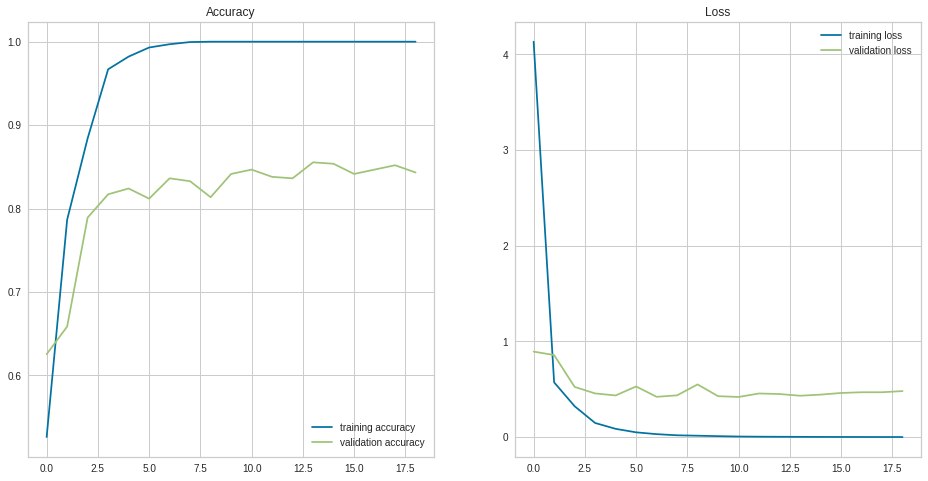

In [ ]:
plot_loss_accuracy_history(history1)

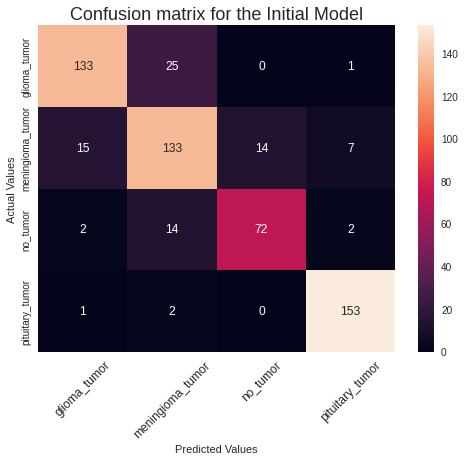

                  precision    recall  f1-score   support

    glioma_tumor       0.88      0.84      0.86       159
meningioma_tumor       0.76      0.79      0.78       169
        no_tumor       0.84      0.80      0.82        90
 pituitary_tumor       0.94      0.98      0.96       156

        accuracy                           0.86       574
       macro avg       0.86      0.85      0.85       574
    weighted avg       0.86      0.86      0.86       574



In [ ]:
show_full_classification_report(model1, valid_ds, "Initial Model")

### Deeper Model 1 (model2)

In [ ]:
model2 = Sequential([
  # layers.Rescaling(1./255, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[0], 1)),
  layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 1)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 5, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(32, activation='relu'),
  layers.Dense(32, activation='relu'),
  layers.Dense(num_classes)
])

model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 512, 512, 16)      160       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 256, 256, 16)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 32)      4640      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 64)      51264     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 64)      

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5, restore_best_weights=True,)
mc = ModelCheckpoint('improved_model1.h5', monitor='val_accuracy', mode='max')

set_seed()

max_epochs=30
history2 = model2.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=max_epochs,
  callbacks=[es, mc]
)

Epoch 1/30
72/72 [==============================] - 23s 299ms/step - loss: 1.1435 - accuracy: 0.5226 - val_loss: 0.8307 - val_accuracy: 0.6672
Epoch 2/30
72/72 [==============================] - 20s 283ms/step - loss: 0.5923 - accuracy: 0.7491 - val_loss: 0.5986 - val_accuracy: 0.7369
Epoch 3/30
72/72 [==============================] - 20s 283ms/step - loss: 0.3241 - accuracy: 0.8624 - val_loss: 0.4675 - val_accuracy: 0.8153
Epoch 4/30
72/72 [==============================] - 20s 285ms/step - loss: 0.1524 - accuracy: 0.9447 - val_loss: 0.3880 - val_accuracy: 0.8589
Epoch 5/30
72/72 [==============================] - 20s 282ms/step - loss: 0.0752 - accuracy: 0.9747 - val_loss: 0.4391 - val_accuracy: 0.8624
Epoch 6/30
72/72 [==============================] - 21s 287ms/step - loss: 0.0425 - accuracy: 0.9852 - val_loss: 0.4983 - val_accuracy: 0.8693
Epoch 7/30
72/72 [==============================] - 20s 283ms/step - loss: 0.0383 - accuracy: 0.9865 - val_loss: 0.5214 - val_accuracy: 0.8659

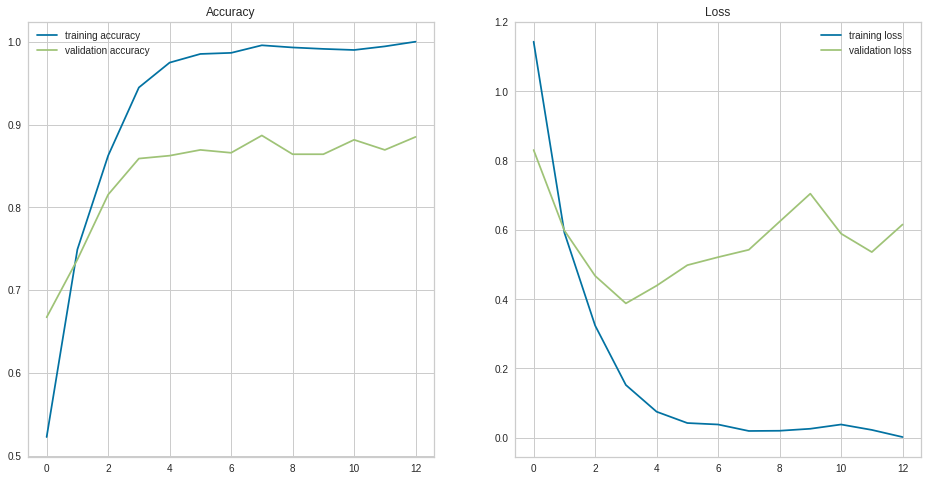

In [ ]:
plot_loss_accuracy_history(history2)

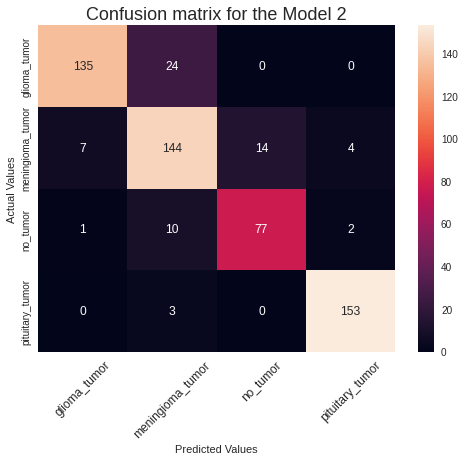

                  precision    recall  f1-score   support

    glioma_tumor       0.94      0.85      0.89       159
meningioma_tumor       0.80      0.85      0.82       169
        no_tumor       0.85      0.86      0.85        90
 pituitary_tumor       0.96      0.98      0.97       156

        accuracy                           0.89       574
       macro avg       0.89      0.88      0.88       574
    weighted avg       0.89      0.89      0.89       574



In [ ]:
show_full_classification_report(model2, valid_ds, "Model 2")

### Deeper Model 2 (model3)

In [ ]:
model3 = Sequential([
  # layers.Rescaling(1./255, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[0], 1)),
  layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 1)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 5, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 5, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 7, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(32, activation='relu'),
  layers.Dense(num_classes)
])

model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 512, 512, 16)      160       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 256, 256, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 256, 256, 32)      4640      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 128, 128, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 128, 128, 64)      51264     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 64, 64, 64)      

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5, restore_best_weights=True,)
mc = ModelCheckpoint('improved_model2.h5', monitor='val_accuracy', mode='max')

set_seed()

max_epochs=30
history3 = model3.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=max_epochs,
  callbacks=[es, mc]
)

Epoch 1/30
72/72 [==============================] - 30s 403ms/step - loss: 1.1179 - accuracy: 0.5013 - val_loss: 0.9589 - val_accuracy: 0.5470
Epoch 2/30
72/72 [==============================] - 29s 407ms/step - loss: 0.7621 - accuracy: 0.6742 - val_loss: 0.7206 - val_accuracy: 0.7003
Epoch 3/30
72/72 [==============================] - 30s 410ms/step - loss: 0.5826 - accuracy: 0.7557 - val_loss: 0.6351 - val_accuracy: 0.7160
Epoch 4/30
72/72 [==============================] - 29s 407ms/step - loss: 0.4604 - accuracy: 0.8071 - val_loss: 0.4944 - val_accuracy: 0.8014
Epoch 5/30
72/72 [==============================] - 30s 408ms/step - loss: 0.3564 - accuracy: 0.8584 - val_loss: 0.4775 - val_accuracy: 0.8136
Epoch 6/30
72/72 [==============================] - 29s 408ms/step - loss: 0.2545 - accuracy: 0.9059 - val_loss: 0.5078 - val_accuracy: 0.8258
Epoch 7/30
72/72 [==============================] - 29s 407ms/step - loss: 0.1758 - accuracy: 0.9286 - val_loss: 0.5126 - val_accuracy: 0.8484

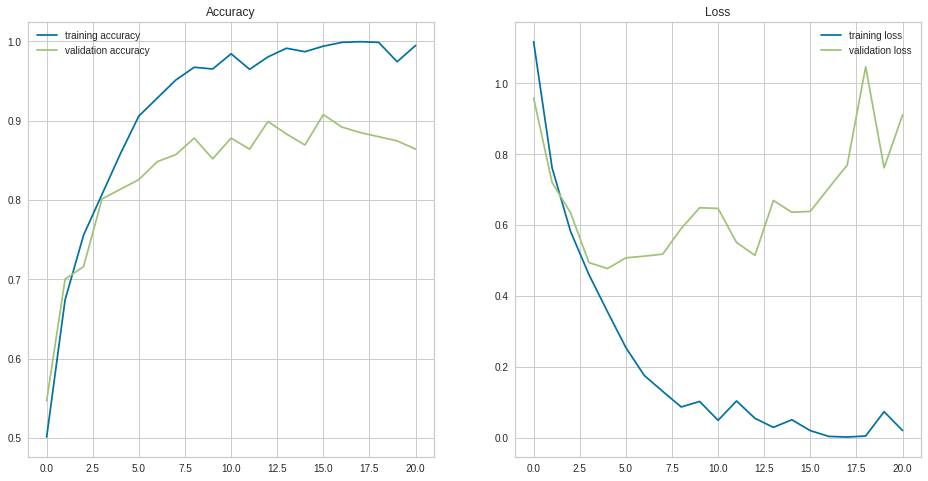

In [ ]:
plot_loss_accuracy_history(history3)

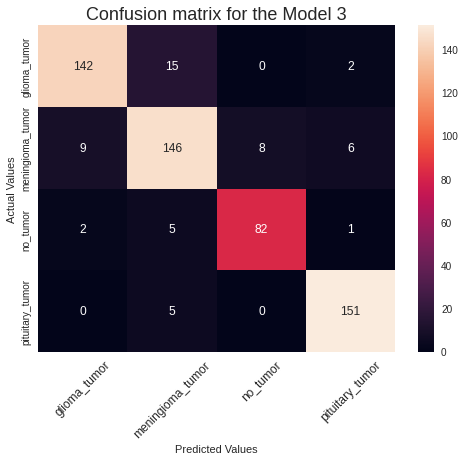

                  precision    recall  f1-score   support

    glioma_tumor       0.93      0.89      0.91       159
meningioma_tumor       0.85      0.86      0.86       169
        no_tumor       0.91      0.91      0.91        90
 pituitary_tumor       0.94      0.97      0.96       156

        accuracy                           0.91       574
       macro avg       0.91      0.91      0.91       574
    weighted avg       0.91      0.91      0.91       574



In [ ]:
show_full_classification_report(model3, valid_ds, "Model 3")

### Model Regularized with Drouput (model4)

In [ ]:
model4 = Sequential([
  # layers.Rescaling(1./255, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[0], 1)),
  layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 1)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 5, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 5, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 7, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.4),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(32, activation='relu'),
  layers.Dense(num_classes)
])

model4.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model4.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 512, 512, 16)      160       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 256, 256, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 256, 256, 32)      4640      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 128, 128, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 128, 128, 64)      51264     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 64, 64, 64)      

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5, restore_best_weights=True,)
mc = ModelCheckpoint('regularized_model_drouput.h5', monitor='val_accuracy', mode='max')

set_seed()

max_epochs=30
history4 = model4.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=max_epochs,
  callbacks=[es, mc]
)

Epoch 1/30
72/72 [==============================] - 30s 409ms/step - loss: 1.2064 - accuracy: 0.4965 - val_loss: 0.8568 - val_accuracy: 0.6167
Epoch 2/30
72/72 [==============================] - 29s 409ms/step - loss: 0.7861 - accuracy: 0.6607 - val_loss: 0.7492 - val_accuracy: 0.6638
Epoch 3/30
72/72 [==============================] - 29s 405ms/step - loss: 0.5884 - accuracy: 0.7574 - val_loss: 0.6062 - val_accuracy: 0.7857
Epoch 4/30
72/72 [==============================] - 30s 409ms/step - loss: 0.4549 - accuracy: 0.8253 - val_loss: 0.5379 - val_accuracy: 0.7787
Epoch 5/30
72/72 [==============================] - 29s 406ms/step - loss: 0.3777 - accuracy: 0.8571 - val_loss: 0.5107 - val_accuracy: 0.8188
Epoch 6/30
72/72 [==============================] - 29s 408ms/step - loss: 0.2986 - accuracy: 0.8898 - val_loss: 0.4723 - val_accuracy: 0.8188
Epoch 7/30
72/72 [==============================] - 29s 407ms/step - loss: 0.2097 - accuracy: 0.9277 - val_loss: 0.4065 - val_accuracy: 0.8693

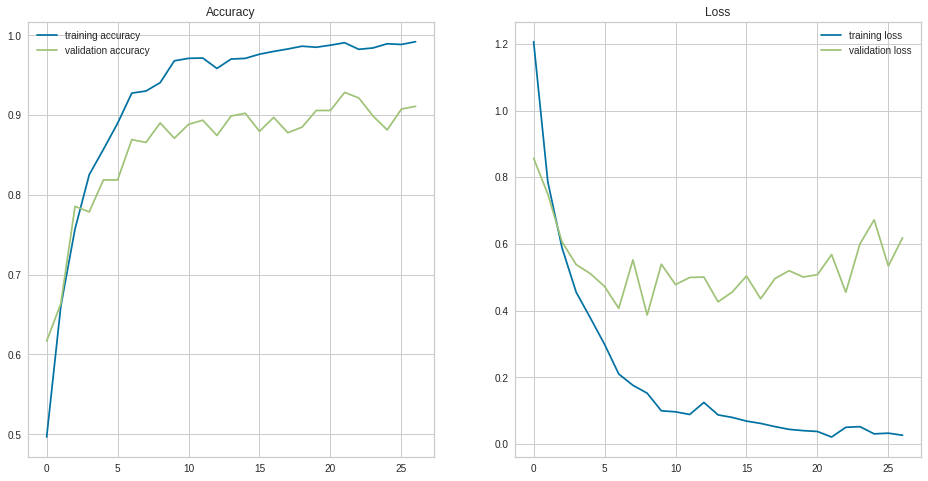

In [ ]:
plot_loss_accuracy_history(history4)

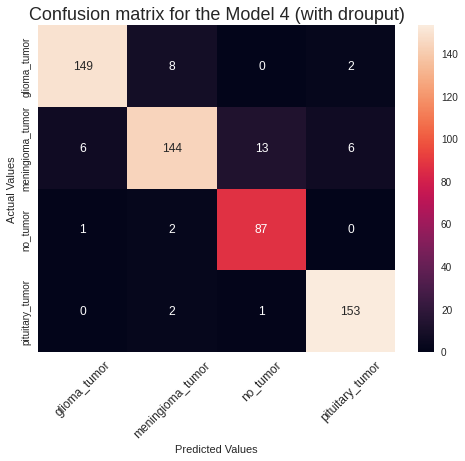

                  precision    recall  f1-score   support

    glioma_tumor       0.96      0.94      0.95       159
meningioma_tumor       0.92      0.85      0.89       169
        no_tumor       0.86      0.97      0.91        90
 pituitary_tumor       0.95      0.98      0.97       156

        accuracy                           0.93       574
       macro avg       0.92      0.93      0.93       574
    weighted avg       0.93      0.93      0.93       574



In [ ]:
show_full_classification_report(model4, valid_ds, "Model 4 (with drouput)")

### Model with class weights

In [ ]:
model5 = Sequential([
  # layers.Rescaling(1./255, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[0], 1)),
  layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 1)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 5, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 5, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 7, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.4),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(32, activation='relu'),
  layers.Dense(num_classes)
])

model5.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model5.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 512, 512, 16)      160       
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 256, 256, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 256, 256, 32)      4640      
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 128, 128, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 128, 128, 64)      51264     
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 64, 64, 64)      

In [ ]:
training_dist = get_distribution(train_ds)

total = np.sum(training_dist)

class_weight = {0: total / training_dist[0],  1: total / training_dist[1], 2: total / training_dist[2], 3: total / training_dist[3]}

np.sum(class_weight)

{0: 3.442278860569715,
 1: 3.5160796324655434,
 2: 7.527868852459016,
 3: 3.421758569299553}

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5, restore_best_weights=True,)
mc = ModelCheckpoint('regularized_model_drouput.h5', monitor='val_accuracy', mode='max')

set_seed()

max_epochs=30
history5 = model5.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=max_epochs,
  callbacks=[es, mc],
  class_weight=class_weight
)

Epoch 1/30
72/72 [==============================] - 30s 401ms/step - loss: 4.9763 - accuracy: 0.4064 - val_loss: 1.0061 - val_accuracy: 0.5732
Epoch 2/30
72/72 [==============================] - 29s 406ms/step - loss: 2.9752 - accuracy: 0.6812 - val_loss: 0.7454 - val_accuracy: 0.7073
Epoch 3/30
72/72 [==============================] - 30s 416ms/step - loss: 2.3739 - accuracy: 0.7465 - val_loss: 0.6017 - val_accuracy: 0.7561
Epoch 4/30
72/72 [==============================] - 29s 406ms/step - loss: 1.9125 - accuracy: 0.8005 - val_loss: 0.5641 - val_accuracy: 0.7875
Epoch 5/30
72/72 [==============================] - 29s 409ms/step - loss: 1.5539 - accuracy: 0.8428 - val_loss: 0.5747 - val_accuracy: 0.7962
Epoch 6/30
72/72 [==============================] - 29s 407ms/step - loss: 1.1604 - accuracy: 0.8950 - val_loss: 0.4449 - val_accuracy: 0.8519
Epoch 7/30
72/72 [==============================] - 29s 407ms/step - loss: 1.0437 - accuracy: 0.8963 - val_loss: 0.4314 - val_accuracy: 0.8641

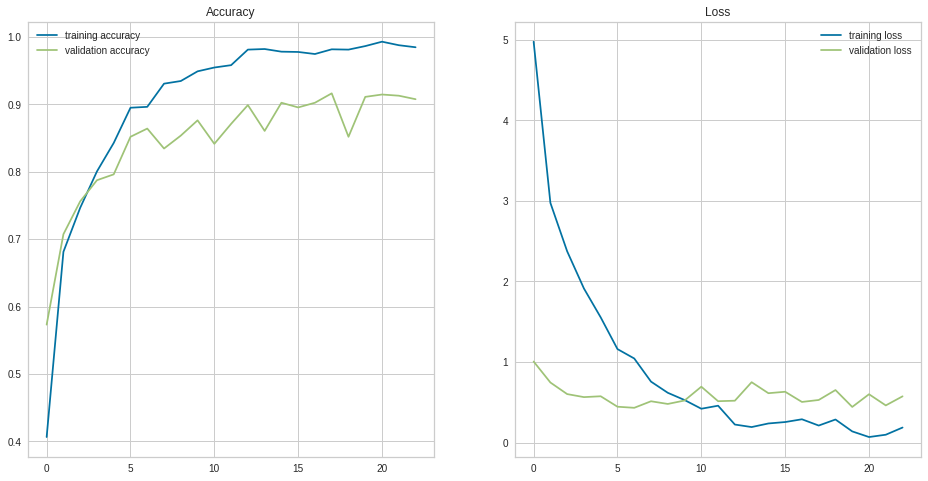

In [ ]:
plot_loss_accuracy_history(history5)

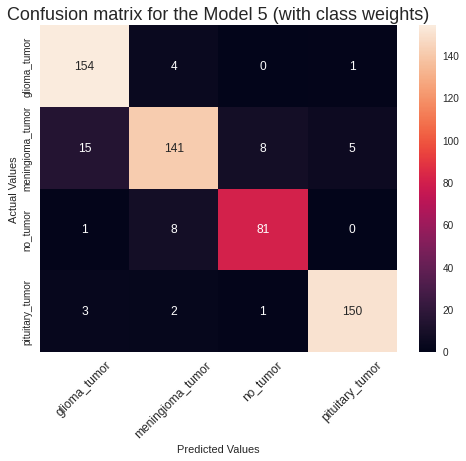

                  precision    recall  f1-score   support

    glioma_tumor       0.89      0.97      0.93       159
meningioma_tumor       0.91      0.83      0.87       169
        no_tumor       0.90      0.90      0.90        90
 pituitary_tumor       0.96      0.96      0.96       156

        accuracy                           0.92       574
       macro avg       0.92      0.92      0.91       574
    weighted avg       0.92      0.92      0.92       574



In [ ]:
show_full_classification_report(model5, valid_ds, "Model 5 (with class weights)")